<a href="https://colab.research.google.com/github/Vishal-Upendran/IUCAASummerSchool2021/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimate actual redshifts from photometric data

We have photometric data -- magnitudes and colors. We will use this to estimate the actual redshift of the object as measured through its spectrum.

## Step wise procedure

1. Data preparation and processing
2. Pre-preparation: Have summary metrics ready.
3. Linear: Regression using Ordinary least squares
4. Non-linear: Let's do a Neural network in pytorch

In [57]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns

# Step 1: Download data

In [3]:
!gdown --id 1D7OZ_ibIjl-2clagDXHBgiX_-BxAycmK 

mkdir: cannot create directory ‘Data/’: File exists
Downloading...
From: https://drive.google.com/uc?id=1D7OZ_ibIjl-2clagDXHBgiX_-BxAycmK
To: /content/Skyserver_12_15_2020 3 45 07 AM.csv
82.5MB [00:01, 51.0MB/s]


In [34]:
!pip install scikit-learn --upgrade

     |████████████████████████████████| 22.3MB 1.3MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [99]:
Data = pd.read_csv("Skyserver_12_15_2020 3 45 07 AM.csv",comment="#")

In [100]:
Data.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237678877245244171,318.951692,9.315146,19.51665,18.50036,17.95667,17.53139,17.32035,7777,301,5,53,819657923239110656,GALAXY,0.114299,728,52520,10
1,1237668332026986542,217.940001,14.608378,19.13548,18.55482,17.95603,17.68272,17.63717,5322,301,3,56,6154252554903769088,QSO,1.802680,5466,56033,304
2,1237664092899115053,129.948221,25.213328,19.54955,18.19434,17.83220,17.51329,17.47054,4335,301,3,130,2173034979993348096,GALAXY,0.070813,1930,53347,175
3,1237654604252119048,160.357788,3.567886,17.72343,16.65830,16.23667,16.07098,16.02797,2126,301,1,275,649647859372681216,STAR,0.000570,577,52367,13
4,1237661360769400880,226.001700,38.619699,16.60500,15.66234,15.39406,15.29443,15.29302,3699,301,2,227,5817649714997514240,STAR,-0.000184,5167,56066,454


In [101]:
#First, replace with nan
Data = Data.replace(-9999.0,np.nan)
Data.dropna(inplace=True)

# Step 2: Convert magnitudes to color.

This step is to ensure "flux" due to distance is removed, and relative intensities between different bands is taken.

In [102]:
df = Data[['class','redshift']]
df['u_g'] = Data['u']-Data['g']
df['g_r'] = Data['g']-Data['r']
df['r_i'] = Data['r']-Data['i']
df['i_z'] = Data['i']-Data['z']

df = df.loc[df['class']=='QSO']

In [103]:
df.head()

,class,redshift,u_g,g_r,r_i,i_z
1,QSO,1.802680,0.58066,0.59879,0.27331,0.04555
8,QSO,0.754256,0.20686,0.09017,0.12023,0.06721
28,QSO,1.681824,0.13062,0.00068,0.20351,0.02154
55,QSO,0.506626,0.23220,0.04590,0.14832,0.03768
57,QSO,0.395499,0.24153,0.55923,0.44332,0.50756


In [104]:
df = df.drop('class',axis=1)

In [105]:
df.columns

Index(['redshift', 'u_g', 'g_r', 'r_i', 'i_z'], dtype='object')

In [106]:
from sklearn.preprocessing import StandardScaler

In [107]:
input_raw = df[['u_g','g_r','r_i','i_z']].values
output_raw = df['redshift'].values
print(input_raw.shape,output_raw.shape)

(54536, 4) (54536,)


In [108]:
output_raw = output_raw.reshape([-1,1])

Text(0, 0.5, 'Counts')

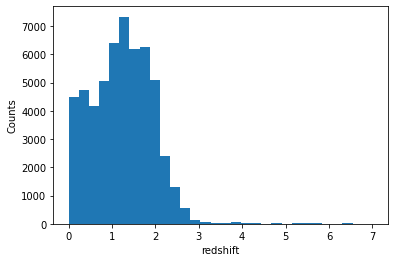

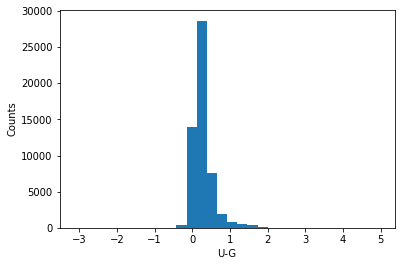

In [109]:
_ = plt.hist(output_raw[:,0],30)
plt.xlabel("redshift")
plt.ylabel("Counts")
plt.figure()
_ = plt.hist(input_raw[:,0],30)
plt.xlabel("U-G")
plt.ylabel("Counts")

In [110]:
scalerx = StandardScaler()
scalery = StandardScaler()

input_mod = scalerx.fit_transform(input_raw)
output_mod = scalery.fit_transform(output_raw)

### Train-test split

In [111]:
idx = np.arange(input_mod.shape[0])

#----------- Shuffle the indices
np.random.seed(2796)
np.random.shuffle(idx)
idx = list(idx)
#-----------------
trainlocs = idx[:int(len(idx) * 0.85)]
xtrain = input_mod[trainlocs,:]
ytrain = output_mod[trainlocs]
print(xtrain.shape,ytrain.shape)

#------------------
testlocs = idx[int(len(idx) * 0.85):]
xtest = input_mod[testlocs]
ytest = output_mod[testlocs]
print(xtest.shape,ytest.shape)

(46355, 4) (46355, 1)
(8181, 4) (8181, 1)


In [112]:
ytrain_og = scalery.inverse_transform(ytrain)
ytest_og = scalery.inverse_transform(ytest)

In [113]:
from sklearn.metrics import mean_absolute_percentage_error,r2_score,mean_squared_error
def Performance(target,prediction):
    print(f"Mean square error: {mean_squared_error(target,prediction)}")
    print(f"Mean absolute percentage error: {mean_absolute_percentage_error(target,prediction)}")
    print(f"R2 score: {r2_score(target,prediction)}")

In [114]:
def Make_scatter_plot(target,prediction):
    plt.figure()
    plt.scatter(target,prediction,s=2.0)
    plt.xlabel("Targets")
    plt.ylabel("predictions")

# First up, let us check how Linear regression works out

We will use $\color{#d08c60}{Scikit-learn}$ to perform linear regression. This assumes the form of our predictor as: 

$$z_{pred,j} = W_{ij}m_{i} + b_j,$$ where $m_{i}$ are the individual colors for each sample, and $j$ corresponds to each sample.



In [115]:
from sklearn.linear_model import LinearRegression

In [116]:
LinReg = LinearRegression()
LinReg.fit(xtrain,ytrain)

LinearRegression()

In [117]:
ytrain_pred = LinReg.predict(xtrain)
ytest_pred = LinReg.predict(xtest)

In [118]:
ytrain_pred = scalery.inverse_transform(ytrain_pred)
ytest_pred = scalery.inverse_transform(ytest_pred)

In [119]:
print("Training set statistics")
Performance(ytrain_og,ytrain_pred)

Training set statistics
Mean square error: 0.4341474455449827
Mean absolute percentage error: 1.6382026041507045
R2 score: 0.11960032422078937


In [120]:
print("Testing set statistics")
Performance(ytest_og,ytest_pred)

Testing set statistics
Mean square error: 0.4130444409033818
Mean absolute percentage error: 2.8755175537844018
R2 score: 0.138727060676193


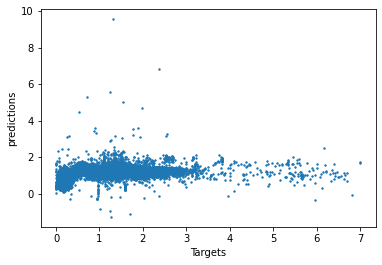

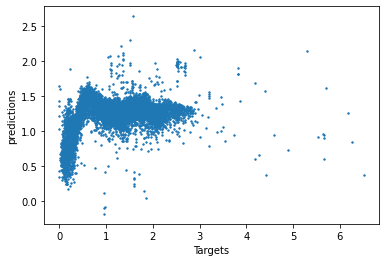

In [121]:
Make_scatter_plot(ytrain_og,ytrain_pred)
Make_scatter_plot(ytest_og,ytest_pred)

That is fine performance for a linear model. But it could be better, so let's code up a neural network and check performance.

# Neural network

We shall use $\color{#dc2f02}{Pytorch}$ to make our neural network. You can use tensorflow or keras or whatever package you like -- pytorch is in vogue now, so we go ahead with it. 

## Pytorch structure

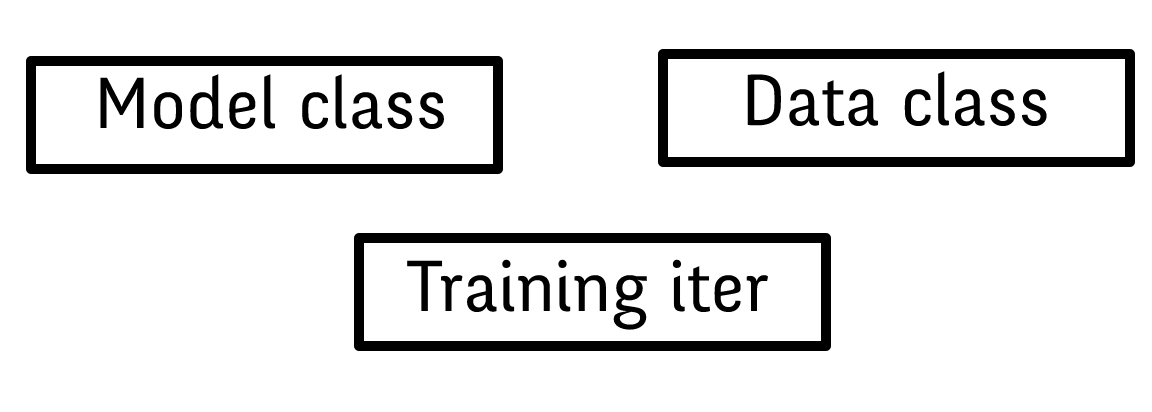

So basically, we need to write a small:
1. Data class, which will give us input and output for a given sample.
2. A model class which will define our network and generate output for a given input.
3. A *for* loop which will iterate over data and train the network.

In [181]:
import torch
import torch.nn as nn
from torch.utils import data

In [182]:
def _float(tensor):
    return torch.Tensor(tensor.astype(np.float32)).float()

In [184]:
class ReDNN(nn.Module):
    def __init__(self,nin,nout):
        super(ReDNN,self).__init__()
        self.NN = nn.Sequential(
                    nn.Linear(nin,12),
                    nn.ELU(inplace=True),
                    nn.Linear(12,26),
                    nn.ELU(inplace=True),
                    nn.Linear(26,14),
                    nn.ELU(inplace=True),
                    nn.Linear(14,7),
                    nn.ELU(inplace=True),
                    nn.Linear(7,nout)
        )
    def forward(self,input_data):
        return self.NN(input_data)

In [185]:
def MSE(true, pred):
    return ((true - pred)**2).mean().detach().cpu().numpy()

def Wrap_performance(true,pred):
    return Performance(true.detach().cpu().numpy(),pred.detach().cpu().numpy())

def loss_fn(true,pred):
    return ((true - pred)**2).mean()


In [186]:
torch.manual_seed(0)

In [187]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [188]:
class Data(data.Dataset):
    def __init__(self,features,target):
        self.features = _float(features).to(device)
        self.target = _float(target).to(device)
        self.nout = target.shape[-1]
        self.nin = features.shape[-1]
    def __len__(self):
        return self.features.shape[0]
    def __getitem__(self,index):
        return self.features[index],self.target[index]

In [189]:
batch_size = 50000
lr = 1e-4
num_epochs = 10000

In [190]:
train_set = Data(xtrain,ytrain)
test_set = Data(xtest,ytest)

training_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
test_loader = data.DataLoader(test_set,batch_size=test_set.features.shape[0],shuffle=True)

In [191]:
#This defines our model
Redshift_model = ReDNN(train_set.nin,train_set.nout)
Redshift_model = Redshift_model.to(device).float()
print(Redshift_model)

ReDNN(
  (NN): Sequential(
    (0): Linear(in_features=4, out_features=12, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=12, out_features=26, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=26, out_features=14, bias=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Linear(in_features=14, out_features=7, bias=True)
    (7): ELU(alpha=1.0, inplace=True)
    (8): Linear(in_features=7, out_features=1, bias=True)
  )
)


In [192]:
optimizer = torch.optim.Adam(Redshift_model.parameters(),lr=lr)

In [193]:
!nvidia-smi

Sun May 30 11:54:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    29W /  70W |   1134MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [194]:
from tqdm.notebook import tqdm

In [ ]:
training_stats = []
testing_stats = []
for i in tqdm(np.arange(num_epochs)):
    mse_loss = []
    for features,target in training_loader:
        optimizer.zero_grad()

        # features = features.to(device)
        # target = target.to(device)

        predictions = Redshift_model(features)

        loss = loss_fn(target, predictions)
        
        loss.backward()
        optimizer.step()

        mse_loss.append(loss.detach().cpu().numpy())
    training_stats.append(np.mean(mse_loss))
    with torch.no_grad():
        mse_loss = []
        for features,target in test_loader:
            # features = features.to(device)
            # target = target.to(device)

            predictions = Redshift_model(features)

            loss = loss_fn(target, predictions)
            mse_loss.append(loss.detach().cpu().numpy())
        
        testing_stats.append(np.mean(mse_loss))
    if i%100==0:
        print(f"Training loss: {training_stats[-1]}")
        print(f"Testing loss: {testing_stats[-1]}")

Training loss: 1.0429177284240723
Testing loss: 1.017622947692871
Training loss: 0.9800375699996948
Testing loss: 0.953595757484436
Training loss: 0.9351933598518372
Testing loss: 0.9074019193649292
Training loss: 0.9020458459854126
Testing loss: 0.8722965121269226
Training loss: 0.8772657513618469
Testing loss: 0.8444474339485168
Training loss: 0.8568972945213318
Testing loss: 0.8202834725379944
Training loss: 0.83929443359375
Testing loss: 0.7991896271705627
Training loss: 0.8225548267364502
Testing loss: 0.7801582217216492
Training loss: 0.8042221665382385
Testing loss: 0.76068115234375
Training loss: 0.7829976677894592
Testing loss: 0.7387610673904419
Training loss: 0.7582754492759705
Testing loss: 0.7133752703666687
Training loss: 0.7299150228500366
Testing loss: 0.6843926906585693
Training loss: 0.6986045837402344
Testing loss: 0.6523605585098267
Training loss: 0.6661053895950317
Testing loss: 0.6192055344581604
Training loss: 0.6363502144813538
Testing loss: 0.589107871055603
Tr

In [ ]:
plt.plot(training_stats,'r')
plt.plot(testing_stats,'b')

In [176]:
|xtmp,ytrain_scaled = train_set[:]
ytrain_scaled = ytrain_scaled.detach().cpu().numpy()
ytrain_pred = Redshift_model(xtmp.to(device)).detach().cpu().numpy()

xtmp,ytest_scaled = test_set[:]
ytest_scaled = ytest_scaled.detach().cpu().numpy()
ytest_pred = Redshift_model(xtmp.to(device)).detach().cpu().numpy()

In [177]:
ytrain_pred = scalery.inverse_transform(ytrain_pred)
ytest_pred = scalery.inverse_transform(ytest_pred)

ytrain_unscaled = scalery.inverse_transform(ytrain_scaled)
ytest_unscaled = scalery.inverse_transform(ytest_scaled)

In [178]:
print("Training set statistics")
Performance(ytrain_unscaled,ytrain_pred)

Training set statistics
Mean square error: 0.1813492327928543
Mean absolute percentage error: 1.4021697044372559
R2 score: 0.6322452083894308


In [179]:
print("Testing set statistics")
Performance(ytest_unscaled,ytest_pred)

Testing set statistics
Mean square error: 0.1826229989528656
Mean absolute percentage error: 2.864990711212158
R2 score: 0.6191977868783356


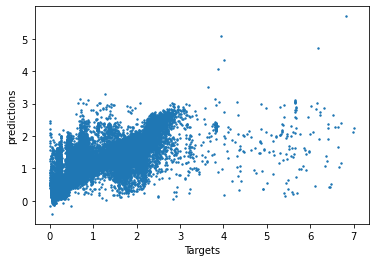

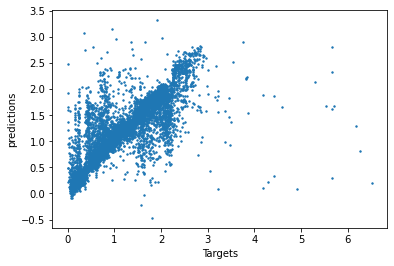

In [180]:
Make_scatter_plot(ytrain_unscaled,ytrain_pred)
Make_scatter_plot(ytest_unscaled,ytest_pred)